# Heart Failure Prediction

Kaggle excerpt:

>Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
    Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

>Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

>People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.


Data Source: https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data

Davide Chicco, Giuseppe Jurman: Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Medical Informatics and Decision Making 20, 16 (2020). Available at: https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5

## Dataset original features:
    - age: Age
    - anaemia: Decrease of red blood cells or hemoglobin (boolean - 0 = No, 1 = Yes)
    - creatinine_phosphokinase: Level of the CPK enzyme in the blood (mcg/L) [Used to investigate if there's tissues stress or damage)
    - diabetes: If the patient has diabetes (boolean - 0 = No, 1 = Yes)
    - ejection_fraction: Percentage of blood leaving the heart at each contraction (percentage)
    - high_blood_pressure: If the patient has hypertension (boolean - 0 = No, 1 = Yes)
    - platelets: Platelets in the blood (kiloplatelets/mL)
    - serum_creatinine: Level of serum creatinine in the blood (mg/dL) [waste product that comes from the normal wear and tear on muscles of the body]
    - serum_sodium: Level of serum sodium in the blood (mEq/L) [helps determine electrolite balancee renal function]
    - sex: Woman or man (binary - Male = 1, Female =0)
    - smoking: 0 = No, 1 = Yes
    - time: captures the time of the event. That is, the time at which the patient died or were censored.
    - DEATH_EVENT: encodes whether the patient died (1) or whether they were censored (0). Censoring means that the scientists lost contact with the patient.
        
Features descriptions gathered from kaggle "About this dataset" and "Discussion" sections. Additional information between '[]'.        

## Importing Packages

In [1]:
import os

import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import researchpy as rp
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from scipy.stats import kruskal
from scipy.stats import f_oneway



from IPython.core.display import display, HTML

## User Defined Functions

In [2]:
def chck_miss(df):
    '''Checking dataset for missing values distribution'''

    Total = df.isnull().count().sort_values(ascending=True)        
    Missing = df.isnull().sum().sort_values(ascending=True)   

    Percentage_Miss = round((Missing/Total)*100,2)

    Summary = pd.concat([Total,Missing, Percentage_Miss],axis=1,keys=['Total','# Missing','% Missing'],sort=True)
          
    print('Are there any missing value?')                    
    print(Summary)         

    del Total, Missing, Percentage_Miss, Summary 

In [3]:
def check_level(df):
    '''Checking dataset categorical features levels'''
    print("Checking the categories levels of categorical features: \n")
    for i in df.columns:
        if (df[i].dtype == object):
            print('These are the categories of \'',i,' \':\n',df[i].unique(), '\n')
    del i 
    

In [4]:
def check_duplicates(df,maintain='last'):
    '''Checking duplicate values in dataset'''
    
    res = df.duplicated().sum()
    print('There are', res , 'duplicated values in dataset.' )
    if res != 0 :
        df.drop_duplicates(keep = maintain,inplace=True)
        if maintain == 'last':
            print('Duplicated values were dropped maintaning only the last occurrence')
        else:
             print('Duplicated values were dropped maintaning only the first occurrence')

In [5]:
def uni_numerical(df,visual='Y',test='N',just_summr='N',alpha=0.05):
    '''This function returns summarization and visual for univariate analysis of numerical features of a dataset. 
    Parameters: dataset,test(Shapiro('S'),Anderson-Darling('AD'), Kolmogorov-Smirnov('KS'), all('A') or None('N'), 
    plot visuals('Y' or 'N',default='Y'),significance level(alpha, default=0.05(0.15,0.1,0.05,0.025,0.01))), 
    just_summr if set to 'Y' will present just the normality tests assumptions (no other parameter will be 
    considered) and summary table with normality tests results for the data set('Y' or 'N',default='N')''' 

#Include The Anderson-Darling test for normality and table with summary an statistical and p-values for normality tests

    print('\nExploratory Data Analysis')
    print('\n############### Univariate analysis - Numerical ###############\n')
    print('\n\nFor normality tests of datasets with few variables, better perform a visual check,e.g: Q-Q plot.')
    print('\n\nFor large datasets, you can present just a summary of normality tests and and other measures values by setting parameter just_summr="y".\n\n')
    
    
    
# Importing packages
    from statsmodels.graphics.gofplots import qqplot
    from seaborn_qqplot import pplot
    import stemgraphic
    #https://github.com/fdion/stemgraphic/blob/master/doc/stemgraphic%20A%20Stem-and-Leaf%20Plot%20for%20the%20Age%20of%20Big%20Data.pdf
    
    from scipy.stats import norm
    from scipy.stats import kstest
    from scipy.stats import shapiro
    from scipy.stats import anderson
    
    
# Setting parameters
    test = test    
    alpha = alpha
    visual = visual
    just_summr = just_summr
    
    
    #For AD normality test - pvalues
    switcher = {0.15:0,
                0.1:1,
                0.05:2,
                0.025:3,
                0.01:4}
    
# Defining functions

    #stem-and-leaf plot
    def sl_plot(x,i):
        fig,ax = stemgraphic.graphic.stem_graphic(x,title='Stem-and_leaf plot for '+ str(i),asc=True,flip_axes=False,
                                                  mirror =False, legend_pos=None,delimiter_color='w',alpha=.5,
                                                  font_kw={'size':4},median_color='r',median_alpha=0.7,
                                                  primary_kw={'size_inches':(10, 15)},figure_only=True )
        #stemgraphic.stem_hist(x, color='b',delimiter_color='w',legend_pos=None)
        #fig, ax = stemgraphic.stem_graphic(x,flip_axes=True)
        #plt.title("Stem-and-Leaf plot for ",i)
        plt.show()


    #Normality tests
    def Kolmogorov(x,i):
        # The test statistic developed by Kolmogorov and Smirnov 
        # to compare distributions was simply the maximum vertical distance between the two functions
        x=x
        i=i
        
        print('Kolmogorov-Smirnov normality test\n')
        print('Mostly used with large samples (n > 50)') ####################### TO confirm!!!!!!!!!!
        print('Assumptions One-sample KS test:\n')
        print('1. The sample is a random sample')
        print('2. The theoretical distribution must be fully specified. The critical values given in tables ')
        print('   (and often by software packages) assume this to be the case. If parameters are estimated from the ')
        print('   data, the test result will be (much) too conservative. If parameters are estimated from the sample, ')
        print('   Lilliefors test should be used instead.) ')
        print('3. The theoretical distribution is assumed to be continuous. If it is discrete (for example the Poisson),')
        print('   the result will be too conservative, although Conover (1999) provides an equivalent approach for ')
        print('   discrete distributions for small samples.[Check Stem-and-leaf plot]')
        print('4. The sample distribution is assumed to have no ties. If there are ties (for example from rounding, ')
        print('   or if the variable under consideration is discrete), the result will be (much) too liberal as the ')
        print('   large steps give an excessively large d. A categorized distribution can be tested with ')
        print('   Kolmogorov-Smirnov by dividing observed differences between cumulative distributions by the number of ')
        print('   observations in the class interval (n). But such a test is too conservative given (a) the distribution')
        print('   is discrete (see above) and (b) power is reduced because the number of observations reduced by a ')
        print('   factor of n. \n')
        print('Source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3693611/')
        print('\n')
        
        stat, p_normal = kstest(x,'norm') 
        
        print('Kolmogorov-Smirnov\'s Statistics=%.3f, p=%.3f' % (stat, p_normal))
        
        return p_normal

    
    def Shapiro(x):
        # The Shapiro test is based on the correlation between the data and the corresponding normal scores 
        
        print("\nShapiro's test\n")
        print('The Shapiro test is based on the correlation between the data and the corresponding normal scores.')
        print('As the dataset being evaluated gets larger, the Shapiro-Wilk test tends to be slightly more ')
        print(    'sensitive to data in the tails which leads to a greater probability of rejecting the null hypothesis ')
        print('Source: https://influentialpoints.com/Training/kolmogorov-smirnov_test-principles-properties-assumptions.htm')
        print('\n')
        
        stat, p_normal = shapiro(x) 
        
        print('Shapiro\'s Statistics=%.3f, p=%.3f' % (stat, p_normal))
        
        
        
        return p_normal
    
    def AnderDarlin(x):
        #Documentation:https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html
                
        print("\nAnderson-Darling's test\n")
        print('The Anderson-Darling test is severely affected by ties[check Stem-and-Leaf plot] in the data due to poor precision.') 
        print(    'When a significant number of ties exist, the Anderson-Darling will frequently reject the data ')
        print(    'as non-normal, regardless of how well the data fits the normal distribution.')
        print('If the returned statistic is larger than these critical values then for the corresponding significance level,')
        print(    'the null hypothesis that the data come from the chosen distribution can be rejected. ')
        print('Source: https://variation.com/wp-content/distribution_analyzer_help/hs140.htm')
        print('\n')
    
        stat, crit_values, sig = anderson(x,dist='norm') 
        
        #switcher = {0.15:0,
        #    0.1:1,
        #    0.05:2,
        #    0.025:3,
         #   0.01:4}

        def switch(alpha1) :
            alpha1=alpha1
            return switcher.get(alpha1)
        
        idx=switch(alpha)
        print('Anderson-Darling\'s Statistics=%.3f, critical value=%.3f' % (stat, crit_values[idx]))
        
        print('\nHypothesis:')
        print('\nH0: Sample may be Gaussian')
        print('H1: Sample does not looks Gaussian ')
        
        print('\nSignificance level:',alpha)
        
        if stat > crit_values[idx]:
            print('\nNormality\'s test result: Sample does not look Gaussian (reject H0)\n\n')
        else:
            print('\nNormality\'s test result: Sample looks Gaussian (fail to reject H0)\n\n')
   
    
    def normal_test(x,i):
        #x =  feature, i = feature's name
        '''Normality test for a feature'''
    # normality test
        print('\n############### Normality tests ###############\n')
        i = i
        x =  x  
        #print("Normality test for: ",i,"\n")
        #stat, p_normal = shapiro(df[i])
        if test == 'KS':
            sl_plot(x,i)
            p_normal = Kolmogorov(x,i) 
            # interpretation
            interp(p_normal)
        elif test == 'S':
            p_normal = Shapiro(x)
            # interpretation
            interp(p_normal)
        elif test == 'AD':
            sl_plot(x,i)
            p_normal = AnderDarlin(x)
               
        else:
            #test
            sl_plot(x,i)
            p_normal = Kolmogorov(x,i) 
            # interpretation
            interp(p_normal)
            print('___________________________\n\n')   
            #test
            p_normal = AnderDarlin(x)
            print('___________________________\n\n') 
            #test
            p_normal = Shapiro(x)
            # interpretation
            interp(p_normal)

                
        print('_____________________________________________________________________________\n\n')
        
        
    def interp(p_norm):
        '''This function presents interpretation for normality test p-value'''
        p_normal = p_norm
        # interpretation
        print('\nHypothesis:')
        print('\nH0: Sample may be Gaussian')
        print('H1: Sample does not looks Gaussian ')
        
        print('\nSignificance level:',alpha)
        
        if p_normal > alpha:
            print('\nNormality\'s test result: Sample looks Gaussian (fail to reject H0)\n\n')
        else:
            print('\nNormality\'s test result: Sample does not look Gaussian (reject H0)\n\n')
        
    def visual_plot(x,i):
        #x =  feature, i = feature's name
        '''This function presents visuals for Uninumerical EDA'''
        features = x
        i = i
    # Visualization
        # Histogram and Boxplot
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.12, .88)})
        f.set_size_inches(10, 6.5)
    #   sns.distplot(a=df[i], hist=True, kde=True, rug=True, ax=ax_hist)
        sns.histplot(x=x, kde=True, ax=ax_hist)
        sns.boxplot(x=x, ax=ax_box)
        ax_box.set_title('Univariate plot')
        ax_box.set(xlabel='')
        f.suptitle("Plots for "+ str(i))
        plt.show()
        
        #Q-Q plot (against a normal distribution)
         
        pplot(df, x=i, y=norm, kind='qq',height=8,display_kws={"identity":True})
        plt.title("QQ Plot")
        plt.show()
        print('_____________________________________________________________________________\n\n')

        
        
        
    def sumr(x):
        '''This function presents summary for Uninumerical EDA'''
    # Setting canvas  
        sns.color_palette("dark")    #, as_cmap=True
        sns.set_context("talk", font_scale=1) #paper, notebook, talk, poster
    # Summarization   
        table = pd.DataFrame() #table to summarise tests statitics and measures
        
        KolmogorovStat=[]
        KolmogorovPval=[]
        
        ADStat=[]
        ADCrit=[]
        
        ShapiroStat=[]
        ShapiroPval=[]
        
        
        df.describe()
        Summary = dict(df.describe())
        features = []
        for i in Summary:
            Summary[i]['count'] = df[i].count()
            Summary[i]['variance'] = df[i].var()
            Summary[i]['IQR'] = Summary[i]['75%'] - Summary[i]['25%']
            Summary[i]['range'] = Summary[i]['max'] - Summary[i]['min']
            Summary[i]['skewness'] = df[i].skew()
            Summary[i]['kurtosis'] = df[i].kurtosis()
            Summary[i]['mode'] = df[i].mode().values #axis='columns'
            #print('\n This is univariate analysis for',"'", i, "'", '\n\n')
           # print('############### Summary ###############')
            #display(pd.DataFrame(Summary[i]))
            

            #KS values
            features.append(i)
            table = table.append(Summary[i], ignore_index=True)
            stat, p_normal = kstest(df[i],'norm') 
            KolmogorovStat.append(stat)
            KolmogorovPval.append(p_normal)
                
            #AD values
            stat, crit_values, sig = anderson(df[i],dist='norm') 
        
            def switch(alpha1) :
                alpha1=alpha1
                return switcher.get(alpha1)
        
            idx=switch(alpha)
            stat, crit_values = stat, crit_values[idx]
        
            ADStat.append(stat)
            ADCrit.append(crit_values)
                
                
            #S values
            stat, p_normal = shapiro(df[i])
            ShapiroStat.append(stat)
            ShapiroPval.append(p_normal)
            
            if just_summr != 'Y':   
                print('\n This is univariate analysis for',"'", i, "'", '\n\n')
                print('############### Summary ###############')
                display(pd.DataFrame(Summary[i]))
            
                if test != 'N' and visual == 'N':
                    normal_test(df[i],i) 
                elif test != 'N' and visual == 'Y':
                    normal_test(df[i],i)                 
                    visual_plot(df[i],i)
                elif test == 'N' and visual == 'Y':    
                    visual_plot(df[i],i)

        table = pd.concat([table,pd.DataFrame(features,columns=['features'])],axis=1, ignore_index=False)
        table['Defined Significance Level'] = alpha
        
        table = pd.concat([table,pd.DataFrame(KolmogorovStat,columns=['Kolmogorov Statistics'])],axis=1, ignore_index=False)
        table = pd.concat([table,pd.DataFrame(KolmogorovPval,columns=['Kolmogorov P-value'])],axis=1, ignore_index=False)
        
        table = pd.concat([table,pd.DataFrame(ADStat,columns=['Anderson-Darling Statistics'])],axis=1, ignore_index=False)
        table = pd.concat([table,pd.DataFrame(ADCrit,columns=['Anderson-Darling Critical Value'])],axis=1, ignore_index=False)
        
        table = pd.concat([table,pd.DataFrame(ShapiroStat,columns=['Shapiro Statistics'])],axis=1, ignore_index=False)
        table = pd.concat([table,pd.DataFrame(ShapiroPval,columns=['Shapiro P-value'])],axis=1, ignore_index=False)
         
        if just_summr != 'Y':   
            print('\n This is univariate analysis for',"'", i, "'", '\n\n')
            print('############### Summary ###############')
            display(pd.DataFrame(Summary[i]))
            
            if test != 'N' and visual == 'N':
                normal_test(df[i],i) 
            elif test != 'N' and visual == 'Y':
                normal_test(df[i],i)                 
                visual_plot(df[i],i)
            elif test == 'N' and visual == 'Y':    
                visual_plot(df[i],i)
              
        
        print('############### Summary ###############\n')    
        
        print('Kolmogorov-Smirnov normality test\n')
        print('Mostly used with large samples (n > 50)') ####################### TO confirm!!!!!!!!!!
        print('Assumptions One-sample KS test:\n')
        print('1. The sample is a random sample')
        print('2. The theoretical distribution must be fully specified. The critical values given in tables ')
        print('   (and often by software packages) assume this to be the case. If parameters are estimated from the ')
        print('   data, the test result will be (much) too conservative. If parameters are estimated from the sample, ')
        print('   Lilliefors test should be used instead.) ')
        print('3. The theoretical distribution is assumed to be continuous. If it is discrete (for example the Poisson),')
        print('   the result will be too conservative, although Conover (1999) provides an equivalent approach for ')
        print('   discrete distributions for small samples.[Check Stem-and-leaf plot]')
        print('4. The sample distribution is assumed to have no ties. If there are ties (for example from rounding, ')
        print('   or if the variable under consideration is discrete), the result will be (much) too liberal as the ')
        print('   large steps give an excessively large d. A categorized distribution can be tested with ')
        print('   Kolmogorov-Smirnov by dividing observed differences between cumulative distributions by the number of ')
        print('   observations in the class interval (n). But such a test is too conservative given (a) the distribution')
        print('   is discrete (see above) and (b) power is reduced because the number of observations reduced by a ')
        print('   factor of n. \n')
        print('Source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3693611/')
        print('\n')        
        
        print("\nAnderson-Darling's test\n")
        print('The Anderson-Darling test is severely affected by ties[check Stem-and-Leaf plot] in the data due to poor precision.') 
        print(    'When a significant number of ties exist, the Anderson-Darling will frequently reject the data ')
        print(    'as non-normal, regardless of how well the data fits the normal distribution.')
        print('If the returned statistic is larger than these critical values then for the corresponding significance level,')
        print(    'the null hypothesis that the data come from the chosen distribution can be rejected. \n')
        print('Source: https://variation.com/wp-content/distribution_analyzer_help/hs140.htm')
        print('\n')
    
        print("\nShapiro's test\n")
        print('The Shapiro test is based on the correlation between the data and the corresponding normal scores.')
        print('As the dataset being evaluated gets larger, the Shapiro-Wilk test tends to be slightly more ')
        print(    'sensitive to data in the tails which leads to a greater probability of rejecting the null hypothesis \n')
        print('Source: https://influentialpoints.com/Training/kolmogorov-smirnov_test-principles-properties-assumptions.htm\nhttps://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html\n')
        print('\n')
        
        
        print('Summary table for Data set')
        display(table[['features', 'count', 'mean', 'std', 'min', '25%','50%', '75%', 'max', 'variance', 'IQR', 'range', 'skewness', 'kurtosis', 'mode', 'Kolmogorov Statistics', 'Kolmogorov P-value', 'Anderson-Darling Statistics', 'Anderson-Darling Critical Value', 'Shapiro Statistics', 'Shapiro P-value', 'Defined Significance Level']])
        
        
    sumr(df)

In [6]:
def uni_categorical(df,# data frame, if variable inform as df[[var]]
                    size=None,# size of the plot to be create: "L" large,otherwise Small
                    label=None, #if the bar plot should have labels and ticks
                    ref=None, # ref add a y-axis reference line inform value
                   ):
    '''This function returns summarization and visual for univariate analysis of categorical features of a dataset'''
    print('############### Univariate analysis - Categorical ###############')
# Setting canvas  
    sns.color_palette("dark")    #, as_cmap=True
    sns.set_context("talk", font_scale=0.8) #paper, notebook, talk, poster

    #extracting only non-numerical features
    df = df.select_dtypes(exclude=np.number) 
    for i in df.columns:
     #   if type(df.loc[0, i]) == str: #checking type of features
# Summarization
            d1 = df[i].value_counts(dropna=False)
            d2 = round(df[i].value_counts(normalize=True,dropna=False)*100, 2)
            d3 = pd.concat([d1, d2], axis=1)
            d3.columns = ['Count', 'Percentage']
            print('\nThis is univariate analysis for', "'", i, "'", '\n', d3)

 # Visualization
            d1 = pd.DataFrame(d1).T
            d1 = pd.melt(d1,var_name=str(i),value_vars=d1) 
            d1[i]=d1[i].fillna('Missing') 
            fig, ax = plt.subplots()
            if size == 'L':
                fig.set_size_inches(22, 10)
            else:
                fig.set_size_inches(8, 8)
            plot1=sns.barplot(y=d1['value'],x=d1[i], data=d1)#,color='darkblue'
            if label == 'Y':
                for p in ax.patches:
                    ax.annotate(int(p.get_height()), 
                    (p.get_x()+p.get_width()/2+.3, p.get_height()),        
                    ha='center',va='center',xytext=(2, 10),textcoords='offset points', rotation=45)
            else:
                plt.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected,'major', 'minor', 'both'
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
            plt.xticks(rotation=45, ha='right') 
            if ref != None:
                plot1.axhline(ref,c='red',label='threshold='+str(ref),linestyle='--')
                plt.legend(loc=1)
            ax.set_title('Univariate plot')
            plt.show()
    print('\n\n')

#### Setting cell size for better visualization

In [7]:
display(HTML("<style>div.output_scroll { height: 99em; }</style>"))

### Setting warnings OFF/ON

In [8]:
warnings.filterwarnings('always')#'ignore'

## Loading Dataset

In [9]:
# Changing Directory
os.chdir(r'D:\Cursos\Repositories\Heart_Failure_Prediction\Data\Raw Data\archive')

df = pd.read_csv('heart_failure_clinical_records_dataset.csv',dtype={'anaemia':str, 
                                                                     'diabetes':str, 
                                                                     'high_blood_pressure':str, 
                                                                     'sex':str,
                                                                     'smoking':str, 
                                                                     'DEATH_EVENT':str})

In [10]:
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


First look at dataset:

In [11]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [12]:
print('Shape of dataset: ',df.shape)

Shape of dataset:  (299, 13)


In [13]:
print('Features types:\n ',df.dtypes) 

Features types:
  age                         float64
anaemia                      object
creatinine_phosphokinase      int64
diabetes                     object
ejection_fraction             int64
high_blood_pressure          object
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                          object
smoking                      object
time                          int64
DEATH_EVENT                  object
dtype: object


Checking for missing values:

## Splitting Data set

Setting target and dividing training and test datasets:

In [14]:
target='DEATH_EVENT'

# Creating copy of df for exploration data analysis:
df_exp = df.copy()

X = df_exp.drop([target],axis=1)
y = df_exp[target]

# Dividing into training and test datasets:

X_train, X_test,y_train,y_test = train_test_split(X,y,random_state=8,test_size=0.3)

# Merging X and y to perform exploratory data analysis

df_exp = pd.concat([X_train, y_train], axis=1, join='inner')

## Exploratory Data Analysis
### Checking categorical features

Exploratory data analysis will be performed only on train data to get the most unbiased estimate

In [15]:
chck_miss(df_exp)

Are there any missing value?
                          Total  # Missing  % Missing
DEATH_EVENT                 209          0        0.0
age                         209          0        0.0
anaemia                     209          0        0.0
creatinine_phosphokinase    209          0        0.0
diabetes                    209          0        0.0
ejection_fraction           209          0        0.0
high_blood_pressure         209          0        0.0
platelets                   209          0        0.0
serum_creatinine            209          0        0.0
serum_sodium                209          0        0.0
sex                         209          0        0.0
smoking                     209          0        0.0
time                        209          0        0.0


There are no missing values in this dataset.

In [16]:
check_level(df_exp)

Checking the categories levels of categorical features: 

These are the categories of ' anaemia  ':
 ['0' '1'] 

These are the categories of ' diabetes  ':
 ['1' '0'] 

These are the categories of ' high_blood_pressure  ':
 ['0' '1'] 

These are the categories of ' sex  ':
 ['1' '0'] 

These are the categories of ' smoking  ':
 ['0' '1'] 

These are the categories of ' DEATH_EVENT  ':
 ['0' '1'] 



#### Recoding values to original meaning to make interpretation meaningful:



In [17]:
df_exp['anaemia'] = df_exp['anaemia'].map({'0':'No','1':'Yes'})
df_exp['diabetes'] = df_exp['diabetes'].map({'0':'No','1':'Yes'})
df_exp['high_blood_pressure'] = df_exp['high_blood_pressure'].map({'0':'No','1':'Yes'})
df_exp['sex'] = df_exp['sex'].map({'0':'Female','1':'Male'})
df_exp['smoking'] = df_exp['smoking'].map({'0':'No','1':'Yes'})
df_exp['DEATH_EVENT'] = df_exp['DEATH_EVENT'].map({'0':'Censored','1':'Died'})


In [18]:
check_duplicates(df_exp)

There are 0 duplicated values in dataset.


##### Checking categorical features, including Target

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' anaemia ' 
      Count  Percentage
No     118       56.46
Yes     91       43.54


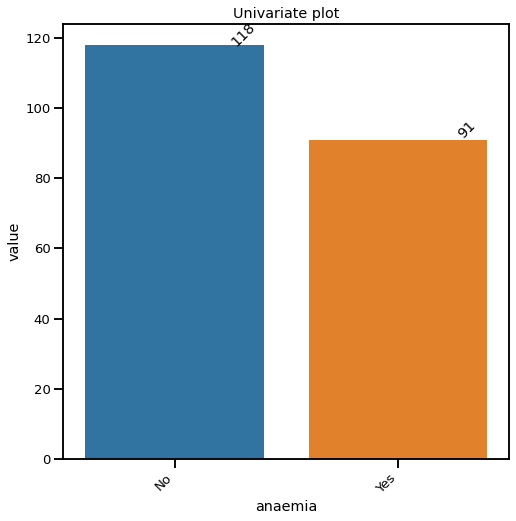


This is univariate analysis for ' diabetes ' 
      Count  Percentage
No     124       59.33
Yes     85       40.67


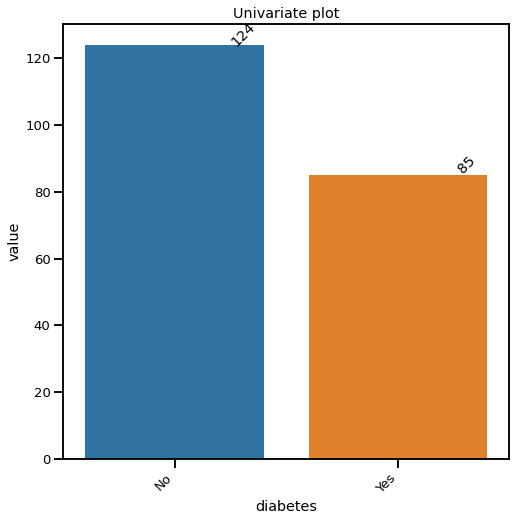


This is univariate analysis for ' high_blood_pressure ' 
      Count  Percentage
No     138       66.03
Yes     71       33.97


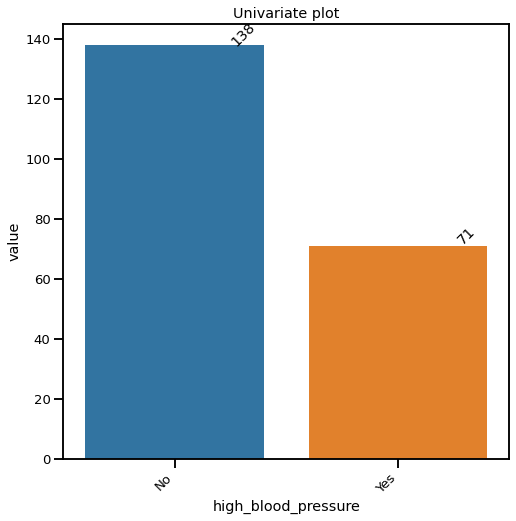


This is univariate analysis for ' sex ' 
         Count  Percentage
Male      130        62.2
Female     79        37.8


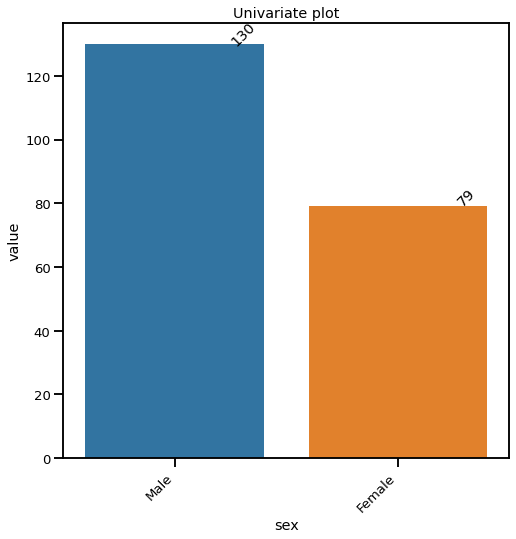


This is univariate analysis for ' smoking ' 
      Count  Percentage
No     143       68.42
Yes     66       31.58


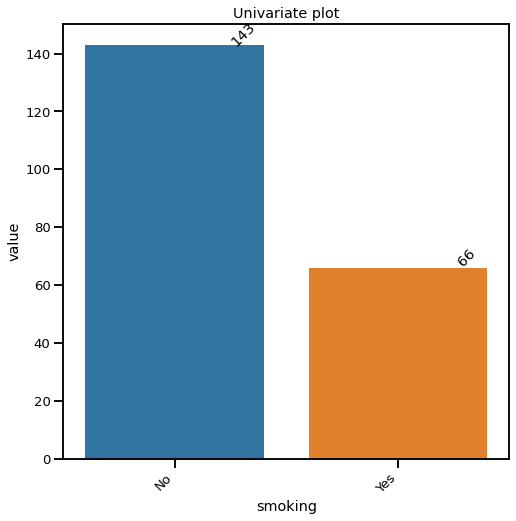


This is univariate analysis for ' DEATH_EVENT ' 
           Count  Percentage
Censored    136       65.07
Died         73       34.93


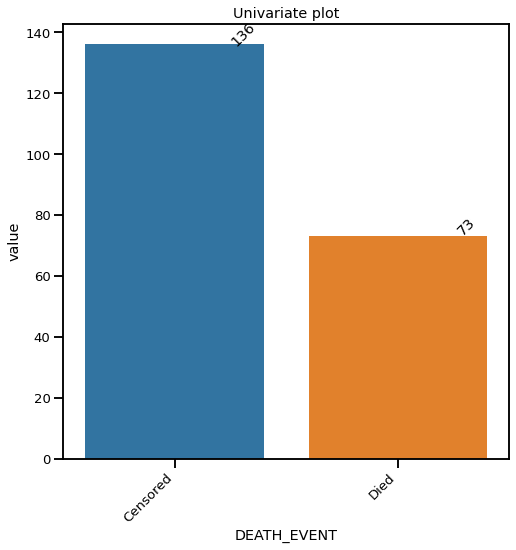

In [19]:
uni_categorical(df_exp, label='Y')

Most features are unbalanced.

Target feature 'DEATH_EVENT' have a high inbalance with most values being Censored.

##### Checking numerical features 

In [20]:
uni_numerical(df,visual='N',test='A',just_summr='Y',alpha=0.05)


Exploratory Data Analysis

############### Univariate analysis - Numerical ###############



For normality tests of datasets with few variables, better perform a visual check,e.g: Q-Q plot.


For large datasets, you can present just a summary of normality tests and and other measures values by setting parameter just_summr="y".


############### Summary ###############

Kolmogorov-Smirnov normality test

Mostly used with large samples (n > 50)
Assumptions One-sample KS test:

1. The sample is a random sample
2. The theoretical distribution must be fully specified. The critical values given in tables 
   (and often by software packages) assume this to be the case. If parameters are estimated from the 
   data, the test result will be (much) too conservative. If parameters are estimated from the sample, 
   Lilliefors test should be used instead.) 
3. The theoretical distribution is assumed to be continuous. If it is discrete (for example the Poisson),
   the result will be too conserva

,features,count,mean,std,min,25%,50%,75%,max,variance,...,skewness,kurtosis,mode,Kolmogorov Statistics,Kolmogorov P-value,Anderson-Darling Statistics,Anderson-Darling Critical Value,Shapiro Statistics,Shapiro P-value,Defined Significance Level
0,age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0,1.414865e+02,...,0.423062,-0.184871,[60.0],1.000000,0.000000e+00,1.642448,0.777,0.975470,5.350570e-05,0.05
1,creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0,9.414586e+05,...,4.463110,25.149046,[582],1.000000,0.000000e+00,41.906127,0.777,0.514263,7.050336e-28,0.05
2,ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0,1.400635e+02,...,0.555383,0.041409,[35],1.000000,0.000000e+00,5.802017,0.777,0.947316,7.215433e-09,0.05
3,platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0,9.565669e+09,...,1.462321,6.209255,[263358.03],1.000000,0.000000e+00,4.989043,0.777,0.911510,2.883745e-12,0.05
4,serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4,1.070211e+00,...,4.455996,25.828239,[1.0],0.741314,1.825773e-169,36.450862,0.777,0.551466,5.392758e-27,0.05
5,serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0,1.946996e+01,...,-1.048136,4.119712,[136],1.000000,0.000000e+00,3.093756,0.777,0.939026,9.210248e-10,0.05
6,time,299.0,130.260870,77.614208,4.0,73.0,115.0,203.0,285.0,6.023965e+03,...,0.127803,-1.212048,"[187, 250]",0.999968,0.000000e+00,4.970228,0.777,0.946783,6.284611e-09,0.05


Age looks normal shaped. Platelets, serum creatinine phosphokinase and serum creatinine have a great number of outliers observations.

# Development
## Next (immediate) phase:  
    Validate uninumerical function and format values to present in summary table
    F